In [27]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# data preparation

### assigning a percentage of the gap area to a tree ID  

In [28]:
NORTH_PATH = './data/correlation_data/mgr - do analizy/North'
SOUTH_PATH = './data/correlation_data/mgr - do analizy/South'

In [29]:
def folder_names(path):
    
    folders = []
    folders = [f for f in sorted(os.listdir(path))]
    
    return folders

In [30]:
def names_of_files_in_directory(path):

    files=[]
    files = [f for f in sorted(os.listdir(path)) if f.endswith('.shp')]
   
    return files

In [24]:
def number_of_erase_shapefiles(files):
    count = 0

    for element in files:
        list_x = element.split('_')
        if len(list_x) == 4:
            count += 1
            
    return count

In [40]:
def create_result_df(path):

    for folder_name in folder_names(path):
        year = str(folder_name.split('_')[-2])
        files = names_of_files_in_directory(path + '/' + folder_name)
        number_of_files = number_of_erase_shapefiles(files)
        export_path = path[:-5] + '/Results/' + path[-5:] +  '/' + year + '.csv'

        data = {}

        for i in range(number_of_files):
            file_path = path + '/' + folder_name + '/' + 'martwe_drzewa_' + year + '_Erase' + str(i) + '_CLIP_' + year + '.shp'
            df = gpd.read_file(file_path)
            
            data[i] = (df['area_x'].sum() / 157.08) * 100

        export_df = pd.DataFrame(data.items(), columns=['ID', 'area'])
        export_df.to_csv(path_or_buf = export_path)


In [41]:
# create_result_df(NORTH_PATH)
# create_result_df(SOUTH_PATH)

### assigning the diameter at breast height to a tree based on the tree number and ID

In [42]:
PATH2 = './data/correlation_data/mgr - do analizy/Spatial joins results'
PATH3 = './data/correlation_data/mgr - do analizy/Results/North'
PATH4 = './data/correlation_data/mgr - do analizy/Results/South'

In [43]:
dbh_dead = pd.read_excel(r'./data/Martwe pnie od 2014.xls')
dbh_dead = dbh_dead[dbh_dead[' pi'].astype(str).str.isdigit()]
dbh_dead.rename(columns = {' pi':'Pierśnica'}, inplace = True)
dbh_dead.head()

,numer,kwa,Unnamed: 2,ka,Pierśnica,Rok,Uwagi,kategorie:,1 - stojące
5,6002.0,80,NaN,2,65,2014,NaN,NaN,NaN
6,6004.0,87.88,NaN,2,50,2014,NaN,NaN,NaN
7,6006.0,87.88,NaN,2,39,2014,NaN,NaN,NaN
8,6008.0,101.102,NaN,2,49,2014,NaN,NaN,NaN
9,6011.0,94.95,NaN,1,36,2014,NaN,NaN,NaN


In [44]:
def assign_stand_gaps(df, year):

    north_path = PATH3 + '/' + str(year) + '.csv'
    gap_file = pd.read_csv(north_path)
    gap_file.rename(columns = {'area': 'north_gap'}, inplace = True)

    df = df.merge(gap_file, left_on = 'ORIG_FID', right_on = 'ID')

    return df

In [97]:
def assign_dbh_to_number(year, intensity_of_dying ,assign_dbh: bool = False):
    
    file_path = '{}/{}.shp'.format(PATH2, year)
    df = gpd.read_file(file_path)
    df.rename(columns = {'areasol_19': 'AreaSol_19', 'piersnica': 'Pierśnica'}, inplace = True)
    
    if assign_dbh:
        try:
            df = df.merge(dbh_dead, left_on = 'Numer', right_on = 'numer')
        except:
            df = df.merge(dbh_dead, left_on = 'numer', right_on = 'numer')
            
    df = assign_stand_gaps(df, year)

    if year == 2014: df['NEAR_DIST'] = 0    
    df = df[['layer_name', 'AreaSol_19', 'NEAR_DIST' ,'Pierśnica', 'north_gap']]
    df['Pierśnica'] = pd.to_numeric(df['Pierśnica'])
    df['Intensywność\nzamierania'] = intensity_of_dying
    
    df.rename(columns = {
        'AreaSol_19': 'Promieniowanie\nsłoneczne',
        'NEAR_DIST': 'Odległóść od\nmartwego\ndrzewa',
        'north_gap': 'Udział\nluki (N)'
    }, inplace = True)
    
    df.replace(0, np.nan, inplace=True)
        
    return df

In [98]:
years_2014_2022 = [
    assign_dbh_to_number(2014, 6.180556, True),
    assign_dbh_to_number(2015, 8.125000, True),
    assign_dbh_to_number(2016, 7.569444, True),
    assign_dbh_to_number(2017, 5.694444, True),
    assign_dbh_to_number(2018, 4.791667),
    assign_dbh_to_number(2019, 1.736111),
    assign_dbh_to_number(2020, 1.875000),
    assign_dbh_to_number(2021, 2.430556),
    assign_dbh_to_number(2022, 2.638889)]

years_2014_2018 = [
    assign_dbh_to_number(2014, 6.180556, True),
    assign_dbh_to_number(2015, 8.125000, True),
    assign_dbh_to_number(2016, 7.569444, True),
    assign_dbh_to_number(2017, 5.694444, True),
    assign_dbh_to_number(2018, 4.791667)]

years_2019_2022 = [
    assign_dbh_to_number(2019, 1.736111),
    assign_dbh_to_number(2020, 1.875000),
    assign_dbh_to_number(2021, 2.430556),
    assign_dbh_to_number(2022, 2.638889)]

df_2014_2022 = pd.concat(years_2014_2022, axis = 0)
df_2014_2018 = pd.concat(years_2014_2018, axis = 0)
df_2019_2022 = pd.concat(years_2019_2022, axis = 0)

In [99]:
# 2014-2022
pearson_df_2014_2022 = df_2014_2022.iloc[:,1:].corr(method = 'pearson')
kendall_df_2014_2022 = df_2014_2022.iloc[:,1:].corr(method = 'kendall')
spearman_df_2014_2022 = df_2014_2022.iloc[:,1:].corr(method = 'spearman')

In [100]:
# 2014-2018
pearson_df_2014_2018 = df_2014_2018.iloc[:,1:].corr(method = 'pearson')
kendall_df_2014_2018 = df_2014_2018.iloc[:,1:].corr(method = 'kendall')
spearman_df_2014_2018 = df_2014_2018.iloc[:,1:].corr(method = 'spearman')

In [101]:
# 2019-2022
pearson_df_2019_2022 = df_2019_2022.iloc[:,1:].corr(method = 'pearson')
kendall_df_2019_2022 = df_2019_2022.iloc[:,1:].corr(method = 'kendall')
spearman_df_2019_2022 = df_2019_2022.iloc[:,1:].corr(method = 'spearman')

### correlation heatmaps

In [102]:
mask = np.triu(np.ones_like(pearson_df_2019_2022))

<Axes: title={'center': 'spearman_df 2019-2022'}>

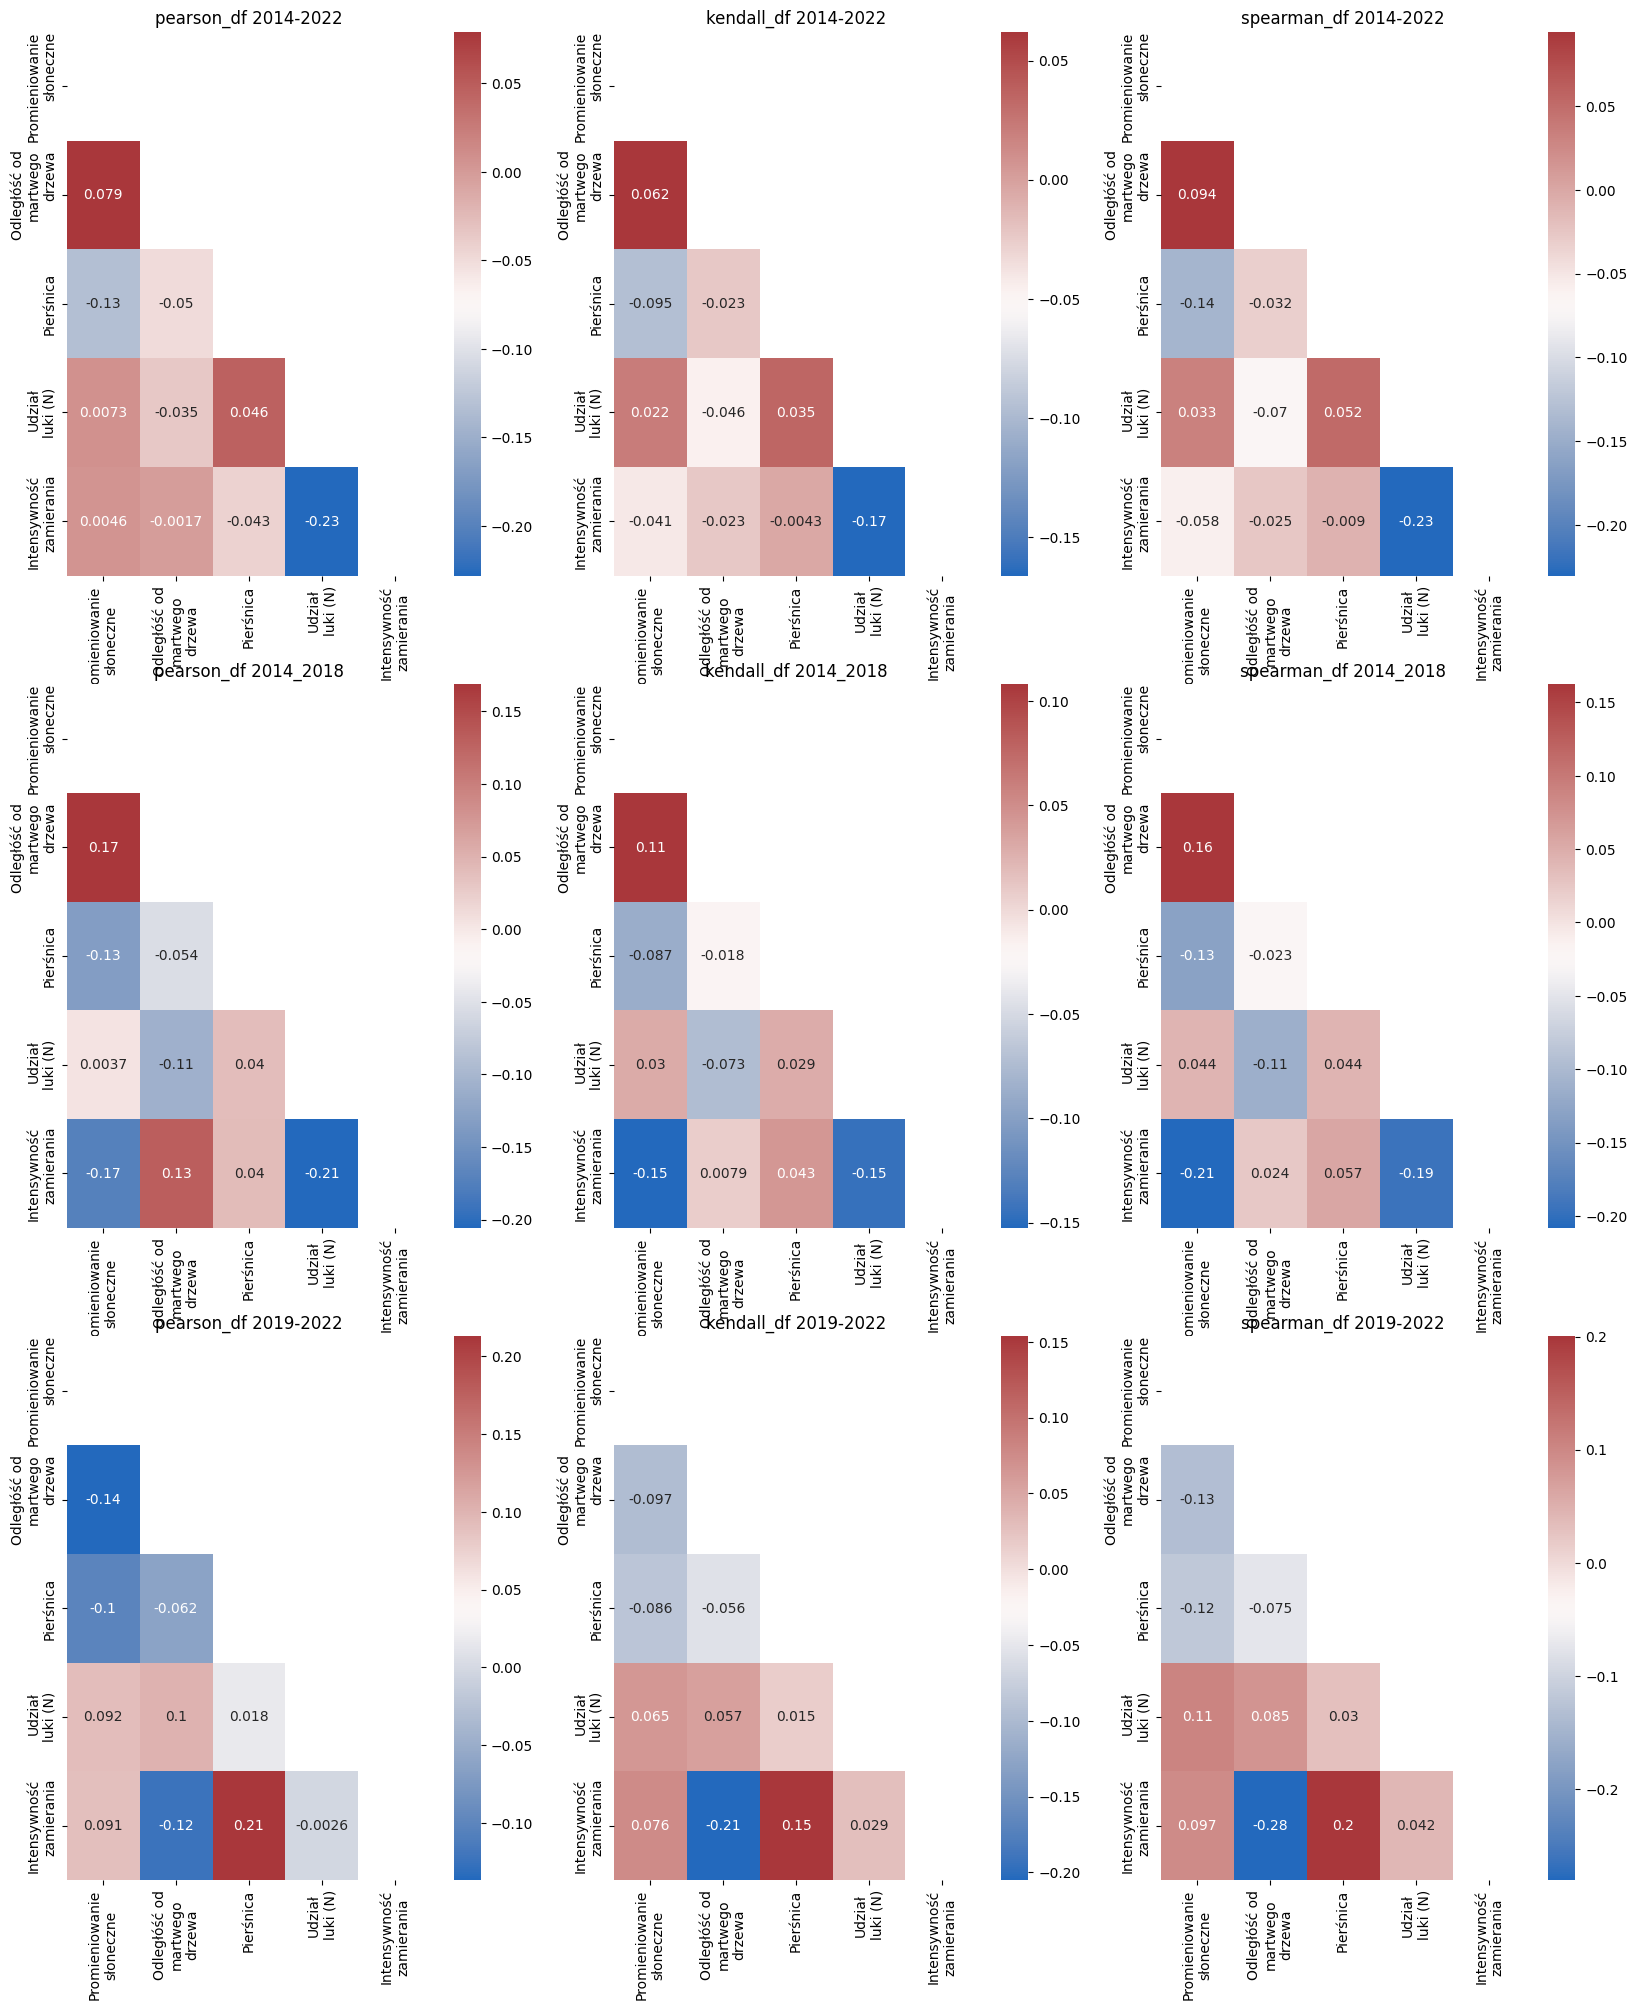

In [103]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]] = plt.subplots(nrows=3, ncols=3, figsize=(20, 24))

ax1.set_title('pearson_df 2014-2022')
ax2.set_title('kendall_df 2014-2022')
ax3.set_title('spearman_df 2014-2022')

ax4.set_title('pearson_df 2014_2018')
ax5.set_title('kendall_df 2014_2018')
ax6.set_title('spearman_df 2014_2018')

ax7.set_title('pearson_df 2019-2022')
ax8.set_title('kendall_df 2019-2022')
ax9.set_title('spearman_df 2019-2022')

sns.heatmap(pearson_df_2014_2022, cmap="vlag", annot=True, mask=mask, ax = ax1)
sns.heatmap(kendall_df_2014_2022, cmap="vlag", annot=True, mask=mask, ax = ax2)
sns.heatmap(spearman_df_2014_2022, cmap="vlag", annot=True, mask=mask, ax = ax3)

sns.heatmap(pearson_df_2014_2018, cmap="vlag", annot=True, mask=mask, ax = ax4)
sns.heatmap(kendall_df_2014_2018, cmap="vlag", annot=True, mask=mask, ax = ax5)
sns.heatmap(spearman_df_2014_2018, cmap="vlag", annot=True, mask=mask, ax = ax6)

sns.heatmap(pearson_df_2019_2022, cmap="vlag", annot=True, mask=mask, ax = ax7)
sns.heatmap(kendall_df_2019_2022, cmap="vlag", annot=True, mask=mask, ax = ax8)
sns.heatmap(spearman_df_2019_2022, cmap="vlag", annot=True, mask=mask, ax = ax9)


<Axes: title={'center': '\n2019-2022'}>

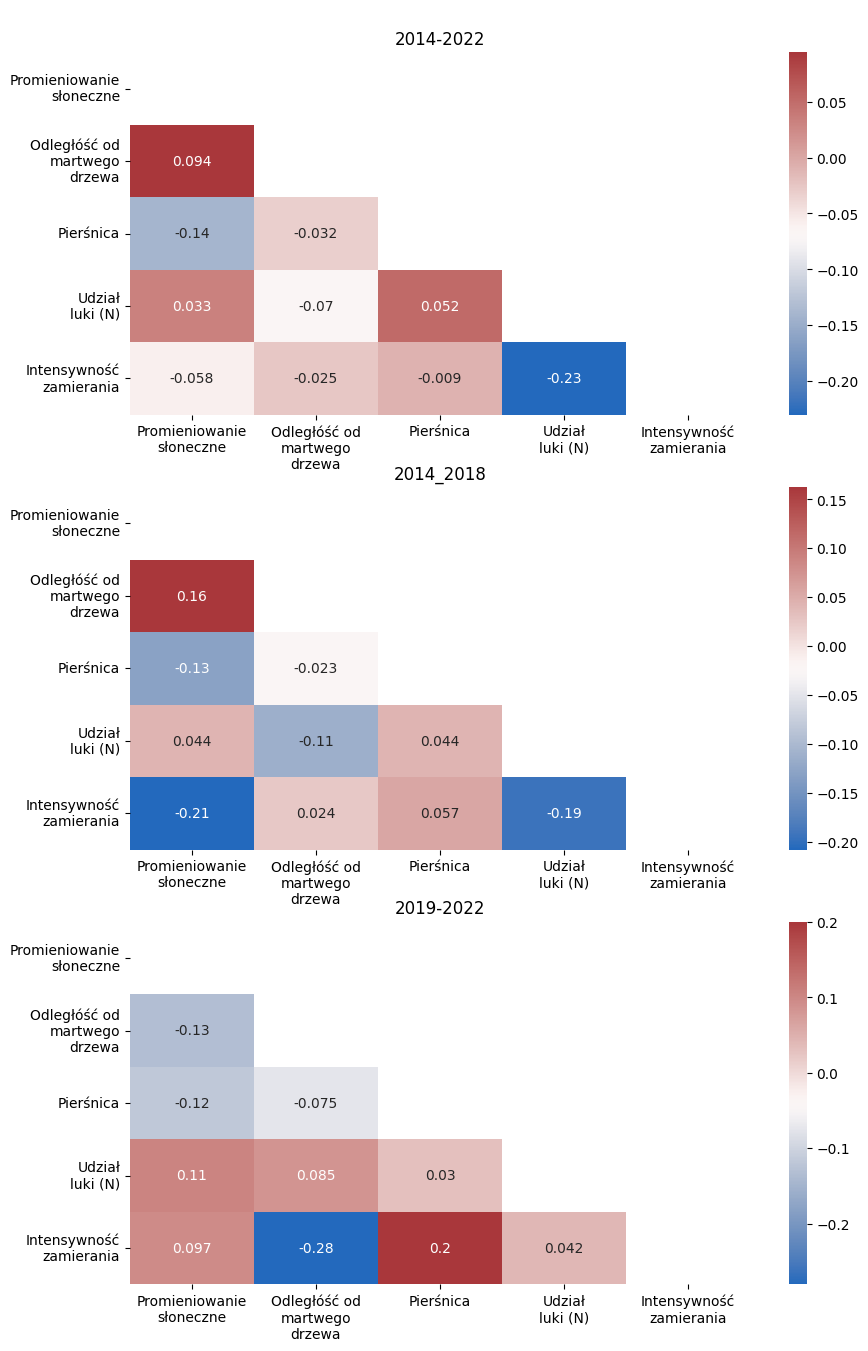

In [104]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=(10, 16))

#spearman

ax1.set_title('\n2014-2022')
ax2.set_title('\n2014_2018')
ax3.set_title('\n2019-2022')

sns.heatmap(spearman_df_2014_2022, cmap="vlag", annot=True, mask=mask, ax = ax1)
sns.heatmap(spearman_df_2014_2018, cmap="vlag", annot=True, mask=mask, ax = ax2)
sns.heatmap(spearman_df_2019_2022, cmap="vlag", annot=True, mask=mask, ax = ax3)